In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [2]:
# Veri seti yolu
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Eğitim ve doğrulama veri setlerini yükle
train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'split_valid',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


Found 70295 files belonging to 38 classes.


2025-05-09 07:53:17.968968: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-09 07:53:17.969004: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-09 07:53:17.969007: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-09 07:53:17.969040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-09 07:53:17.969054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 12284 files belonging to 38 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'split_test',
    image_size=(224, 224),
    batch_size=1,
    label_mode='categorical',
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))


Found 5288 files belonging to 38 classes.


In [3]:

# Sınıf isimleri
class_names = train_ds.class_names

# Veri artırımı
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Preprocessing + Augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(preprocess_input(x), training=True), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

In [4]:
# EfficientNetB0 taban modeli
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # İlk aşamada dondur

# Model mimarisi
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
# Derleme
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop])




Epoch 1/20


2025-05-09 07:53:41.319168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 441s 199ms/step - accuracy: 0.4861 - loss: 2.0062 - val_accuracy: 0.8834 - val_loss: 0.4568
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 437s 199ms/step - accuracy: 0.8544 - loss: 0.5136 - val_accuracy: 0.9209 - val_loss: 0.2897
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 452s 206ms/step - accuracy: 0.8966 - loss: 0.3514 - val_accuracy: 0.9300 - val_loss: 0.2369
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 443s 202ms/step - accuracy: 0.9154 - loss: 0.2806 - val_accuracy: 0.9360 - val_loss: 0.2071
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 445s 203ms/step - accuracy: 0.9280 - loss: 0.2360 - val_accuracy: 0.9442 - val_loss: 0.1795
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 437s 199ms/step - accuracy: 0.9367 - loss: 0.2069 - val_accuracy: 0.9489 - val_loss: 0.1626
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 435s 198ms/step - accuracy: 0.9391 - loss: 0.1948 - val_accuracy: 0.9532 - val_loss: 0.1502
Epoch 8/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 435s 198ms/step - accuracy: 0.9

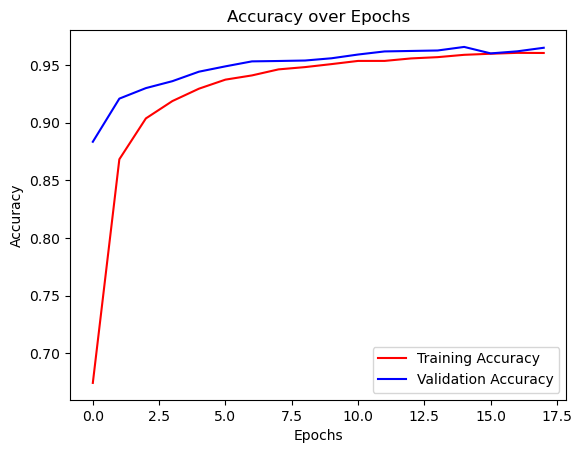

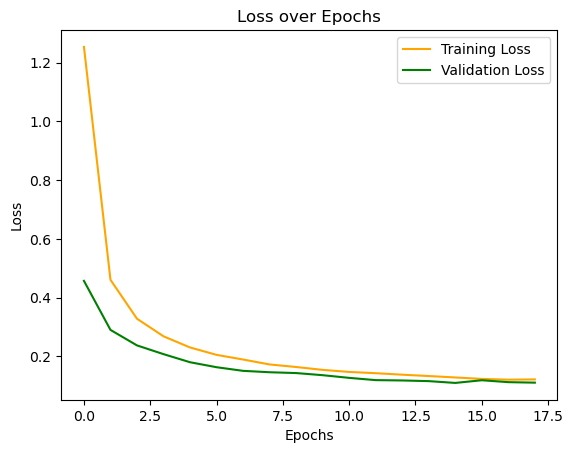

In [7]:
# Modeli kaydet
model.save('Efficientnetb0_transfer_plant_model.keras')

# Eğitim geçmişi kaydet
with open('Efficientnet_history.json', 'w') as f:
    json.dump(history.history, f)

# Başarı grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Kayıp grafiği
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Found 5288 files belonging to 38 classes.
5288/5288 ━━━━━━━━━━━━━━━━━━━━ 118s 22ms/step


2025-05-09 10:13:54.424240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.97      0.98       152
                                 Apple___Black_rot       0.99      1.00      0.99       150
                          Apple___Cedar_apple_rust       1.00      0.96      0.98       132
                                   Apple___healthy       0.98      0.99      0.98       151
                               Blueberry___healthy       0.99      1.00      1.00       137
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       127
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       137
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.84      0.90       123
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       144
               Corn_(maize)___Northern_Leaf_Blight       0.88      0.97      0.

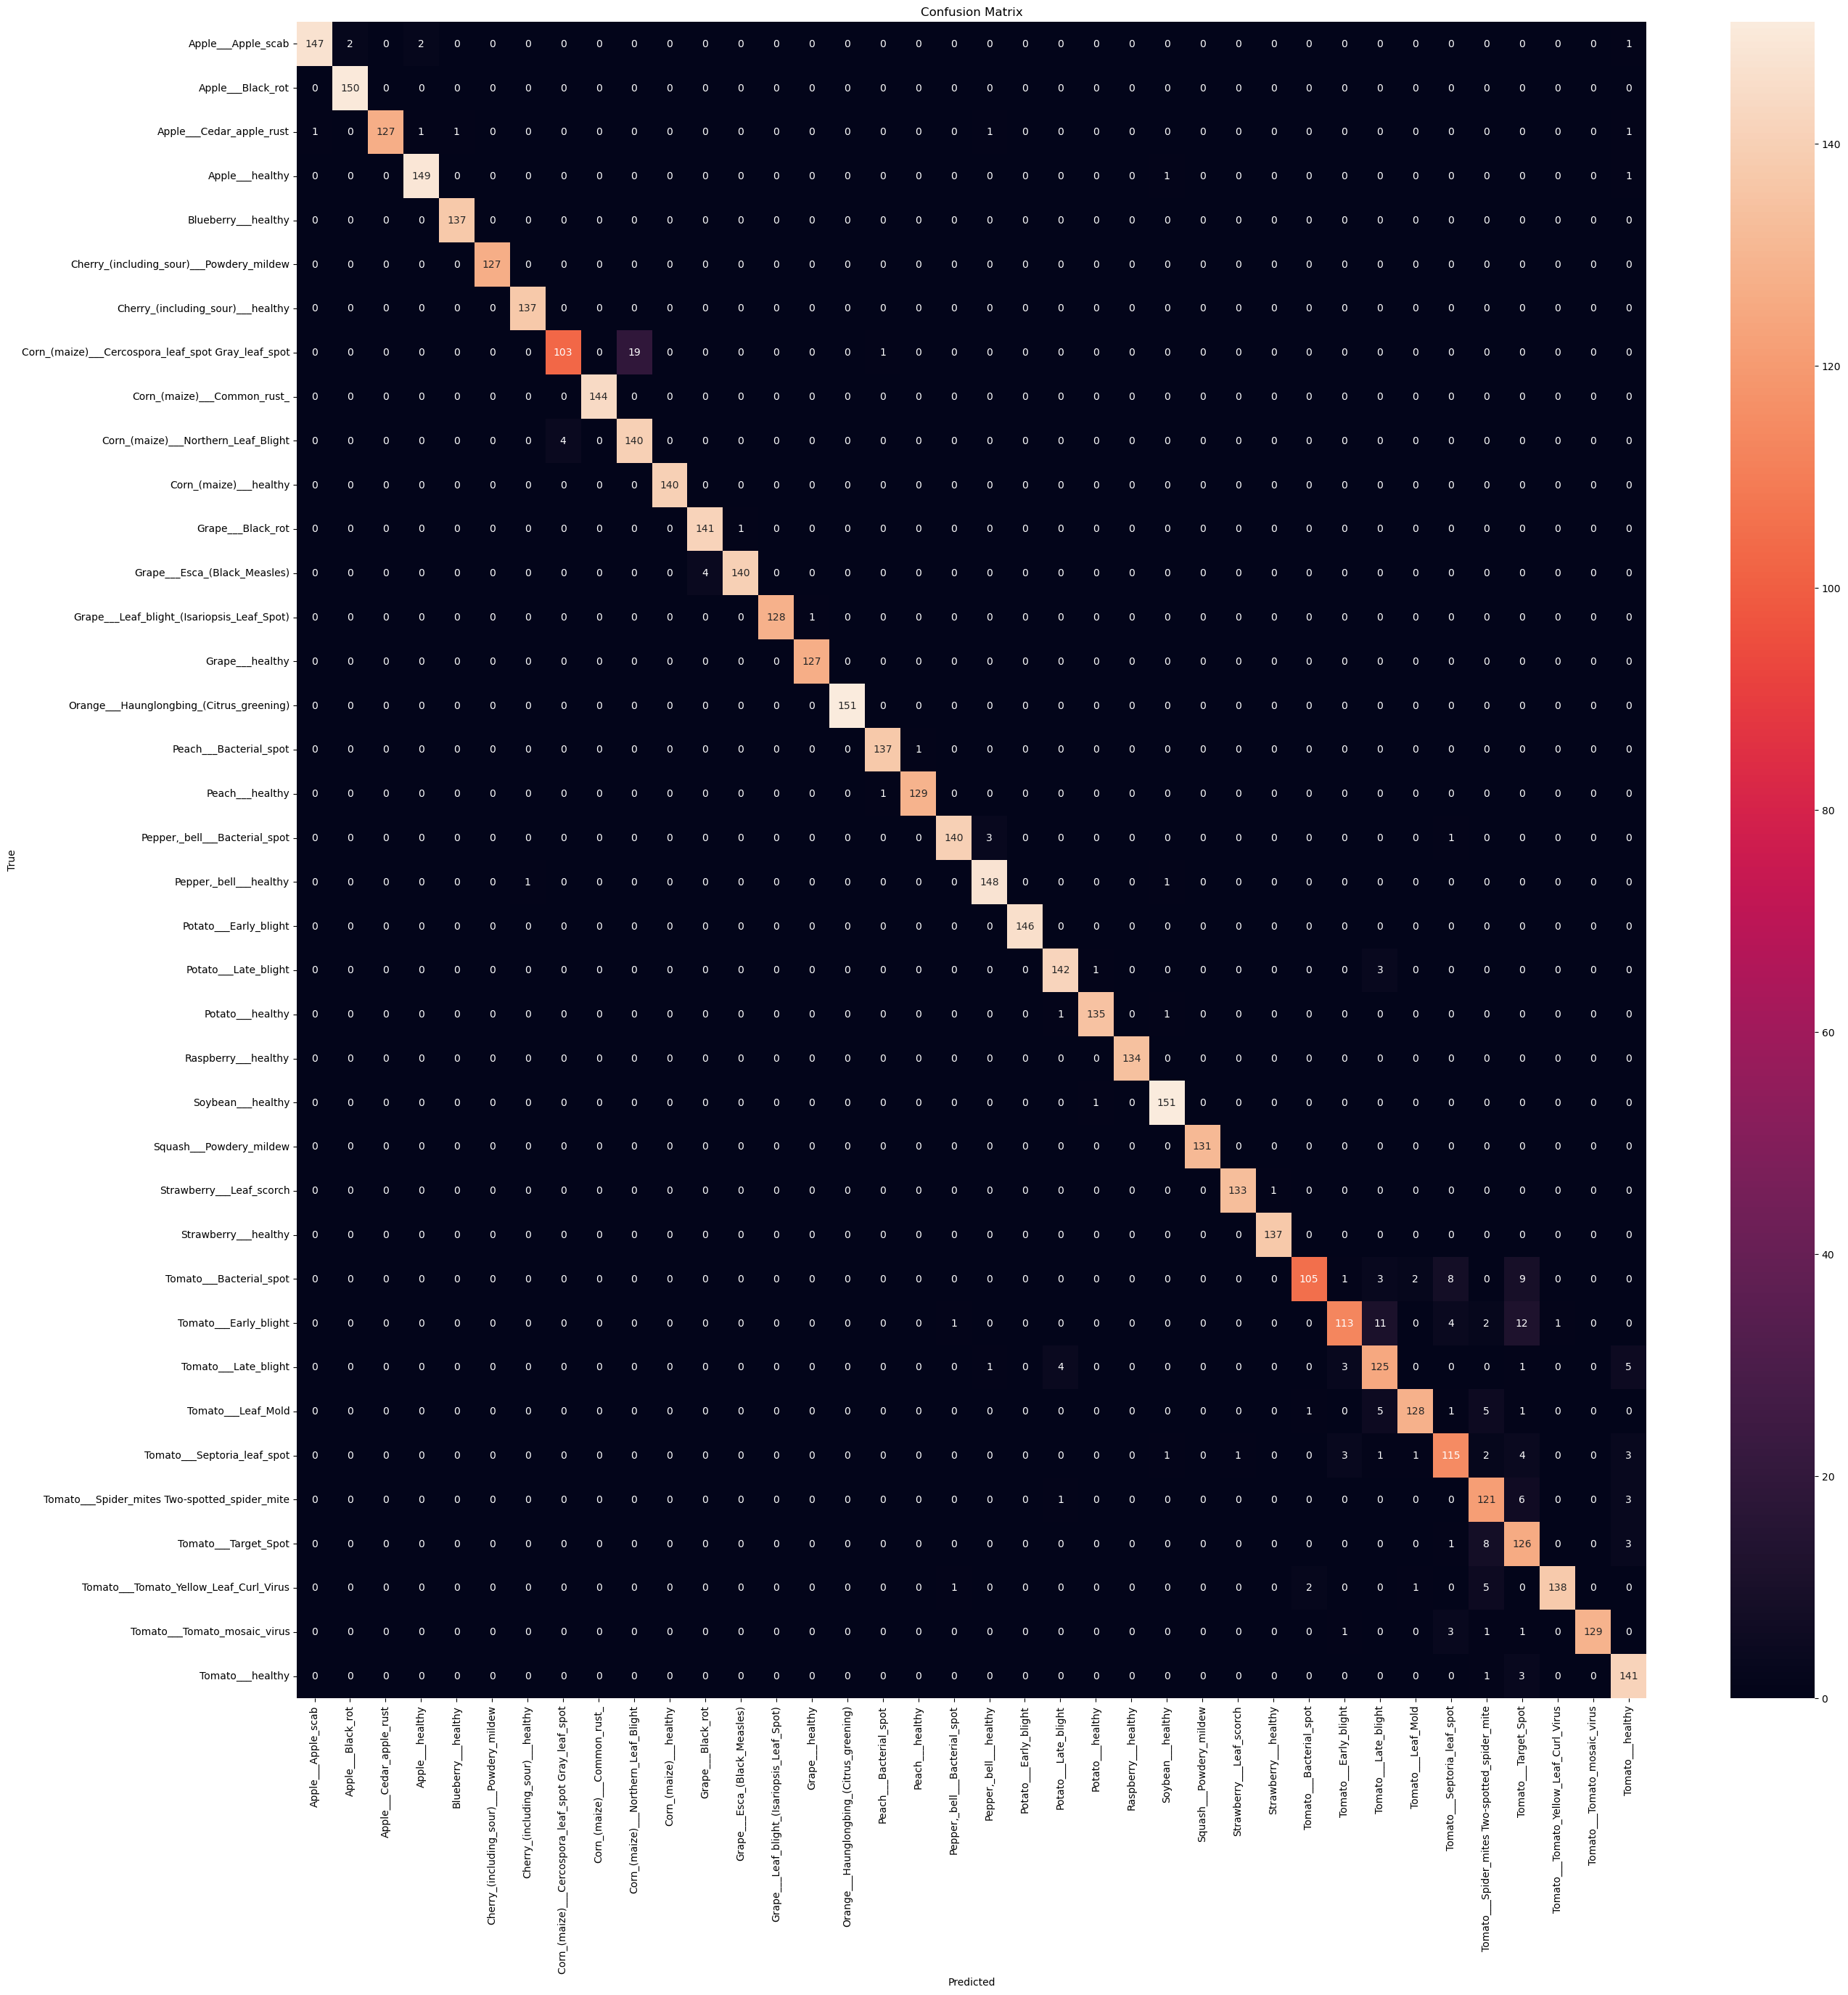

In [8]:
# Test veri seti
test_ds = tf.keras.utils.image_dataset_from_directory(
    'split_test',
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='categorical',
    shuffle=False
)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Tahminler
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_classes = np.argmax(y_true, axis=1)

# Sınıflandırma raporu
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix görselleştirme
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



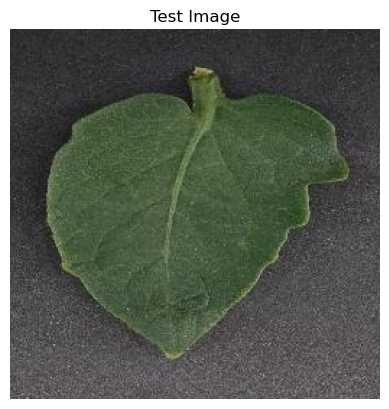

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Model Tahmini: Tomato___healthy


In [13]:
# Tek görsel ile tahmin
image_path = 'test/test/TomatoHealthy2.JPG'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Test Image')
plt.axis('off')
plt.show()

img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
img_array = img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
print(f"Model Tahmini: {predicted_class}")
